In [130]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

#### Datu ielāde

In [131]:
df = pd.read_json('5cat_big.json')
df.drop(['title', 'link'], axis=1, inplace=True)
df.head()

,category,body
0,bizness,"Gaļas pārstrādes uzņēmums AS ""HKScan Latvia"" ..."
1,bizness,Aizvadītajā nedēļā elektroenerģijas cenas sama...
2,bizness,"Lidosta ""Rīga"" šā gada jūliju noslēgusi ar re..."
3,bizness,"2023. gada jūlijā, salīdzinot ar 2022. gada jū..."
4,bizness,Ņemot vērā iedzīvotāju publiski izskanējušās b...


#### Kategorijas vērtības uz integer

In [132]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(df["category"])
df['encod_cat'] = le.transform(df['category'])
# Sanity-check kategorijas datu kodējumam
print(df.head(5))
print(df.category.value_counts())
print(df.encod_cat.value_counts())

  category                                               body  encod_cat
0  bizness  Gaļas pārstrādes uzņēmums AS "HKScan  Latvia" ...          0
1  bizness  Aizvadītajā nedēļā elektroenerģijas cenas sama...          0
2  bizness  Lidosta  "Rīga" šā gada jūliju noslēgusi ar re...          0
3  bizness  2023. gada jūlijā, salīdzinot ar 2022. gada jū...          0
4  bizness  Ņemot vērā iedzīvotāju publiski izskanējušās b...          0
category
politika    1633
criminal    1286
izklaide    1261
sports      1180
bizness     1165
Name: count, dtype: int64
encod_cat
3    1633
1    1286
2    1261
4    1180
0    1165
Name: count, dtype: int64


#### Sadalam datus 80/20

In [133]:
x_train, x_test, y_train, y_test = train_test_split(
    df['body'], df['encod_cat'], test_size=.2, stratify=df['category'], random_state=42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(5220,) (1305,) (5220,) (1305,)


In [134]:
import string
import json
punct = string.punctuation
stopwordsFile = open('stopwords-lv2.json', 'r', encoding="utf8")
stopwords_arr = json.load(stopwordsFile)
print(stopwords_arr)

['aiz', 'ap', 'apakš', 'apakšpus', 'ar', 'arī', 'augšpus', 'bet', 'bez', 'bija', 'biji', 'biju', 'bijām', 'bijāt', 'būs', 'būsi', 'būsiet', 'būsim', 'būt', 'būšu', 'caur', 'diemžēl', 'diezin', 'droši', 'dēļ', 'esam', 'esat', 'esi', 'esmu', 'gan', 'gar', 'iekam', 'iekams', 'iekām', 'iekāms', 'iekš', 'iekšpus', 'ik', 'ir', 'it', 'itin', 'iz', 'ja', 'jau', 'jeb', 'jebšu', 'jel', 'jo', 'jā', 'ka', 'kamēr', 'kaut', 'kolīdz', 'kopš', 'kā', 'kļuva', 'kļuvi', 'kļuvu', 'kļuvām', 'kļuvāt', 'kļūs', 'kļūsi', 'kļūsiet', 'kļūsim', 'kļūst', 'kļūstam', 'kļūstat', 'kļūsti', 'kļūstu', 'kļūt', 'kļūšu', 'labad', 'lai', 'lejpus', 'līdz', 'līdzko', 'ne', 'nebūt', 'nedz', 'nekā', 'nevis', 'nezin', 'no', 'nu', 'nē', 'otrpus', 'pa', 'par', 'pat', 'pie', 'pirms', 'pret', 'priekš', 'pār', 'pēc', 'starp', 'tad', 'tak', 'tapi', 'taps', 'tapsi', 'tapsiet', 'tapsim', 'tapt', 'tapāt', 'tapšu', 'taču', 'te', 'tiec', 'tiek', 'tiekam', 'tiekat', 'tieku', 'tik', 'tika', 'tikai', 'tiki', 'tikko', 'tiklab', 'tiklīdz', 'tik

In [135]:
def filter_stop_words(train_sentences):
    for i, sentence in enumerate(train_sentences):
        new_sent = [word for word in sentence.split() if word not in stopwords_arr]
        train_sentences.iloc[i]  = ' '.join(new_sent)
    return train_sentences
x_train = filter_stop_words(x_train)


#### Tokenizācija

In [136]:
vocab_size = 20000
token_filter = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>', filters=token_filter, lower=True)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
x_seq = tokenizer.texts_to_sequences(x_train)

#### Pārbaudam max sequence garumu

In [137]:
print(max([len(e) for e in x_seq]))

3088


#### Pevienojam padding, visas rindas būs ar vienādu garumu

In [138]:
padding_type = 'post'
print(max([len(e) for e in x_seq]))
max_len = 3100
x_train = pad_sequences(x_seq, padding=padding_type, maxlen=max_len)
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test), padding=padding_type, maxlen=max_len)

3088


In [139]:
x_train.shape

(5220, 3100)

#### Neironu tīkla izveide ar konvolūcijas slāni

In [140]:
model = tf.keras.Sequential([
                            tf.keras.layers.Embedding(vocab_size, 32, input_length=x_train.shape[1]),
                            tf.keras.layers.Conv1D(128, 5, activation='relu'),
                            tf.keras.layers.GlobalMaxPooling1D(),
                            tf.keras.layers.Dense(32, activation='relu'),
                            tf.keras.layers.Dropout(0.2),
                            tf.keras.layers.Dense(df['category'].nunique(), activation='softmax')
])

In [141]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 3100, 32)          640000    
                                                                 
 conv1d_6 (Conv1D)           (None, 3096, 128)         20608     
                                                                 
 global_max_pooling1d_6 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_12 (Dense)            (None, 32)                4128      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 5)                 165       
                                                      

In [142]:
model_save_path='./models/KNT_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True)]

#### Apmācam neironu tīklu 10 etapos

In [143]:
%%time
rezultats = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=2, callbacks=callbacks)

Epoch 1/10
164/164 - 19s - loss: 1.2924 - accuracy: 0.4565 - val_loss: 0.6774 - val_accuracy: 0.7900 - 19s/epoch - 113ms/step
Epoch 2/10
164/164 - 18s - loss: 0.3899 - accuracy: 0.8872 - val_loss: 0.2178 - val_accuracy: 0.9280 - 18s/epoch - 109ms/step
Epoch 3/10
164/164 - 18s - loss: 0.1020 - accuracy: 0.9762 - val_loss: 0.1704 - val_accuracy: 0.9425 - 18s/epoch - 108ms/step
Epoch 4/10
164/164 - 18s - loss: 0.0326 - accuracy: 0.9952 - val_loss: 0.1756 - val_accuracy: 0.9441 - 18s/epoch - 108ms/step
Epoch 5/10
164/164 - 18s - loss: 0.0142 - accuracy: 0.9989 - val_loss: 0.1777 - val_accuracy: 0.9410 - 18s/epoch - 109ms/step
Epoch 6/10
164/164 - 18s - loss: 0.0085 - accuracy: 0.9992 - val_loss: 0.1929 - val_accuracy: 0.9494 - 18s/epoch - 110ms/step
Epoch 7/10
164/164 - 18s - loss: 0.0067 - accuracy: 0.9994 - val_loss: 0.2024 - val_accuracy: 0.9502 - 18s/epoch - 110ms/step
Epoch 8/10
164/164 - 18s - loss: 0.0044 - accuracy: 0.9998 - val_loss: 0.2085 - val_accuracy: 0.9464 - 18s/epoch - 110

41/41 [==============================] - 1s 20ms/step
(1305,)
(1305,)
              precision    recall  f1-score   support

           0      0.903     0.914     0.908       233
           1      0.988     0.965     0.976       257
           2      0.933     0.944     0.939       252
           3      0.935     0.917     0.926       327
           4      0.963     0.987     0.975       236

    accuracy                          0.944      1305
   macro avg      0.944     0.946     0.945      1305
weighted avg      0.944     0.944     0.944      1305



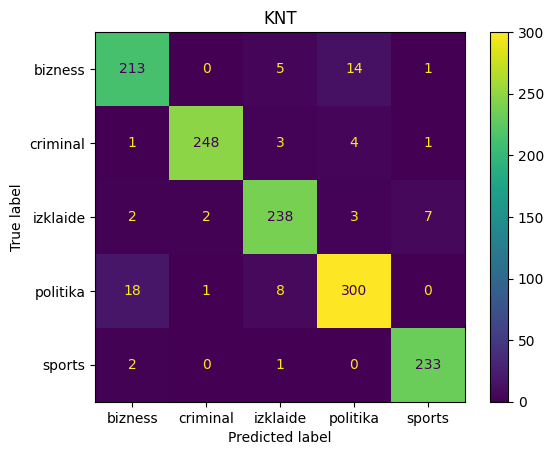

In [144]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print(y_test.shape)
print(y_pred.shape)
cm = confusion_matrix(y_test, y_pred)
labels = ['bizness', 'criminal', 'izklaide', 'politika', 'sports']
plot = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
plot.plot()
plot.ax_.set_title("KNT")
print(classification_report(y_test, y_pred, digits=3))
clsf_report = pd.DataFrame(classification_report(y_true = y_test, y_pred = y_pred, output_dict=True)).transpose()
accuracy_4dig = round(accuracy_score(y_test, y_pred), 4)
filenameCsv = 'Report KNT_'+ str(accuracy_4dig) + '.csv'
clsf_report.to_csv(Path(".") / 'metrics' / filenameCsv, index= True)


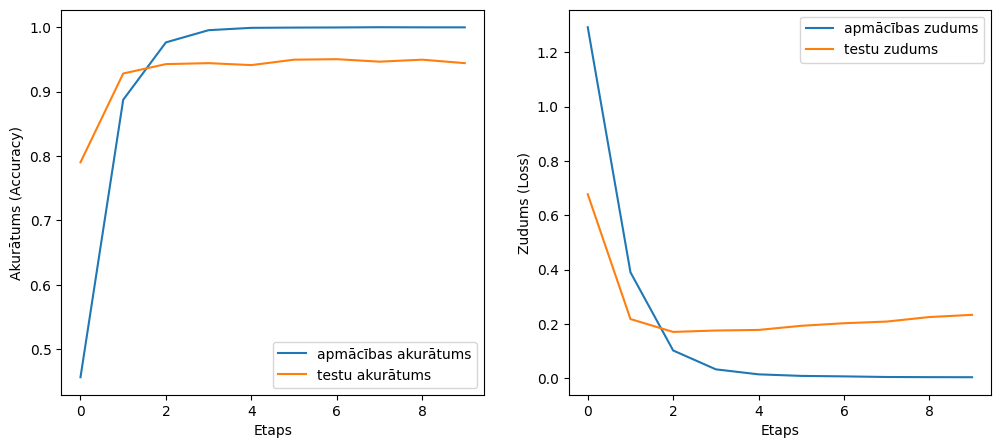

In [145]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
ax = plt.subplot(121)
plt.plot(rezultats.history['accuracy'])
plt.plot(rezultats.history['val_accuracy'])
plt.xlabel("Etaps")
plt.ylabel("Akurātums (Accuracy)")
plt.legend(['apmācības akurātums', 'testu akurātums'])
plt.subplot(122)
plt.plot(rezultats.history['loss'])
plt.plot(rezultats.history['val_loss']);
plt.xlabel("Etaps")
plt.ylabel("Zudums (Loss)")
plt.legend(['apmācības zudums', 'testu zudums']);

In [146]:
def getLabel(index):
    labels = ['bizness', 'criminal', 'izklaide', 'politika', 'sports']
    return labels[index]

In [147]:
def predict(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    prediction = model.predict(padded)
    predictionList = prediction.tolist()[0]
    labeled_predictions = [{getLabel(i):"%.2f%%"%(x*100)} for i, x in enumerate(predictionList)]
    return labeled_predictions

In [148]:
predict("""Pirmdien, 4. septembrī, premjera amatam nominētā Evika Siliņa (JV) sāks nākamās koalīcijas sarunas, dalot ministru amatus "Jaunās Vienotības", Zaļo un zemnieku savienības (ZZS) un partijas "Progresīvie" starpā.

Piektdien, 1. septembrī, Siliņa preses konferencē informēja, ka, "Apvienotajam sarakstam" nepiekrītot darboties nākamajā koalīcijā, tajā darbosies trīs politiskie spēki, kuriem Saeimā kopumā ir 52 balsis.

Siliņa gan neizslēdza iespēju, ka ar laiku koalīcijai varētu pievienoties vēl kāds partneris. "Vienmēr pastāv iespēja iegūt vairāk balsis, ja labi strādā," teica Siliņa.

Kā viens no potenciālajiem nākamās koalīcijas atbalstītājiem varētu būt pie frakcijām nepiederošais Oļegs Burovs, ar kuru Siliņa gan neesot runājusi, bet to darot cits nākamās koalīcijas partneris.""")

1/1 [==============================] - 0s 15ms/step


[{'bizness': '0.00%'},
 {'criminal': '0.01%'},
 {'izklaide': '0.02%'},
 {'politika': '99.97%'},
 {'sports': '0.00%'}]

In [149]:
predict("""Starptautiskais pašapkalpošanās un automatizācijas risinājumu ražotājs "Omnic" Liepājā būvēs jaunu rūpnīcu, lai ražotu pakomātus Eiropas tirgum, liecina uzņēmuma sniegtā informācija.

Šobrīd vēl tiek precizēta potenciāli vislabākā atrašanās vieta ražotnei, bet pirmie būvdarbi varētu tikt uzsākti jau šogad.

Darbu jaunā rūpnīca varētu sākt 2024. gadā.

Kā norāda uzņēmumā, šobrīd vēl esot grūti pateikt precīzas Liepājas rūpnīcas izmaksas, bet līdzīgā ražotnē Gruzijā "Omnic" investēja 8 miljonus eiro.

Liepājas rūpnīcā plānots ražot paku skapīšus, pašapkalpošanās kases aparātus, ar saules paneļiem aprīkotus pakomātus, paku skapīšus-ledusskapjus, kā arī dažādus citus pašapkalpošanās un automatizācijas risinājumus.""")

1/1 [==============================] - 0s 15ms/step


[{'bizness': '87.79%'},
 {'criminal': '1.02%'},
 {'izklaide': '1.91%'},
 {'politika': '9.07%'},
 {'sports': '0.21%'}]

In [150]:
predict("""Aizvadītajā diennaktī valstī reģistrēti 136 ceļu satiksmes negadījumi, tajos cietušas 13 personas, liecina Valsts policijas apkopotie dati.

Četri no cietušajiem bijuši gājēji, tāpat cietis viens velosipēdists un viens elektrisko skrejriteņu vadītājs.

Kopumā ceļu satiksmes jomā pieņemti 456 administratīvo pārkāpumu lēmumi, tajā skaitā 195 par ātruma pārsniegšanu un viens par agresīvu braukšanu.""")

1/1 [==============================] - 0s 16ms/step


[{'bizness': '0.00%'},
 {'criminal': '99.93%'},
 {'izklaide': '0.02%'},
 {'politika': '0.04%'},
 {'sports': '0.00%'}]

In [151]:
predict("""Serbijas tenisists Novaks Džokovičs piektdien ASV atklātā čempionāta trešās kārtas spēlē pret savu tautieti Laslo Džeri zaudēja pirmajos divos setos, tomēr atspēlējās un svinēja uzvaru.

Ranga vicelīderis Džokovičs ATP 38.numuru Džeri vairāk nekā trīsarpus stundu cīņā uzvarēja ar rezultātu 4-6, 4-6, 6-1, 6-1, 6-3.

Kopš 2007.gada Džokovičs visos "US Open" turnīros, kuros piedalījies, ticis tālāk par trešo kārtu, 2011., 2015. un 2018.gadā kļūstot par čempionu.

"Esmu parādījis, ka varu aizvadīt arī piecu setu mačus. Atspēlēšanās pēc diviem zaudētiem setiem rāda skaidru signālu maniem nākamajiem pretiniekiem, taču nav tā, ka vēlējos nonākt šādā situācijā. Labprāt uzvarētu trīs setos," pēc uzvaras teica Džokovičs.""")

1/1 [==============================] - 0s 14ms/step


[{'bizness': '0.05%'},
 {'criminal': '0.00%'},
 {'izklaide': '0.00%'},
 {'politika': '0.00%'},
 {'sports': '99.95%'}]

In [152]:
predict("""Populārā latviešu dziedātāja Samanta Tīna Poļakova "Instagram" vietnē pavēstījusi, ka teikusi jāvārdu savam draugam. Viņas pirkstā iemirdzējies gredzentiņš ar akmeni sirds formā.

34 gadus vecā dziedātāja vēsta: "Jā!" un, apskāvusi savu mīļoto, ziņo, ka saderināšanās notikusi 30. augustā. Vairāki desmiti tūkstoši Samantas sekotāji priecīgo ziņu novērtējuši atzinīgi.

Samanta Tīna līdz šim nav atklājusi, kā sauc viņas mīļoto vīrieti jau labu laiku māksliniece izvēlējusies savu privāto dzīvi neafišēt.

Pirms trim gadiem dziedātāja šķīrās no sava ilgaddējā drauga Naura Liepiņa. Šajā pavasarī TV raidījumā "Kad viņas satiekas" Samanta atklāja, ka vairs nav brīvas meitenes statusā ar mīļoto iepazinusies 2022. gada rudenī pirms sev nozīmīgā ceļojuma uz Indiju. Puiša vārdu neatklājot, māksliniece vēstīja, ka abi iepazinušies attālināti un pēc ilgākas sarakstes pirmo reizi satikušies Samantas koncertā.""")

1/1 [==============================] - 0s 13ms/step


[{'bizness': '0.00%'},
 {'criminal': '0.00%'},
 {'izklaide': '100.00%'},
 {'politika': '0.00%'},
 {'sports': '0.00%'}]